In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [40]:
df=pd.read_csv("data/L030_TI_High_VEL020_fs1000.csv")
df.head()

,t [s],az NO FLAT [m/s2],az WITH FLAT [m/s2]
0,5.670,-9.80999,-9.80999
1,5.671,-9.80999,-9.80999
2,5.672,-9.80999,-9.80999
3,5.673,-9.80999,-9.80999
4,5.674,-9.80999,-9.80999


In [42]:
t = df['t [s]'].to_numpy()
az_no_flat = df['az NO FLAT [m/s2]'].to_numpy()
az_with_flat = df['az WITH FLAT [m/s2]'].to_numpy()

print('Mean az no flat:',np.mean(az_no_flat))
print('Mean az flat:', np.mean(az_with_flat))

az_no_flat = az_no_flat - np.mean(az_no_flat)
az_with_flat = az_with_flat - np.mean(az_with_flat)

fs=1e3
#fs=1/np.mean(np.diff(t))
print('Sampling freq:',fs,'Hz')
N=len(t)
print('Number of samples:', N)


v=20e3/3600
print('Lineal velocity:',v,'m/s')
r=0.46
print('Radius:',r,'m')
fr=v/(2*np.pi*r)
print('Rotational freq:',fr,'Hz')

print('Initial time:',t[0],'s')

Mean az no flat: -9.809570537387504
Mean az flat: -9.81345842531758
Sampling freq: 1000.0 Hz
Number of samples: 27001
Lineal velocity: 5.555555555555555 m/s
Radius: 0.46 m
Rotational freq: 1.9221611484528422 Hz
Initial time: 5.67 s


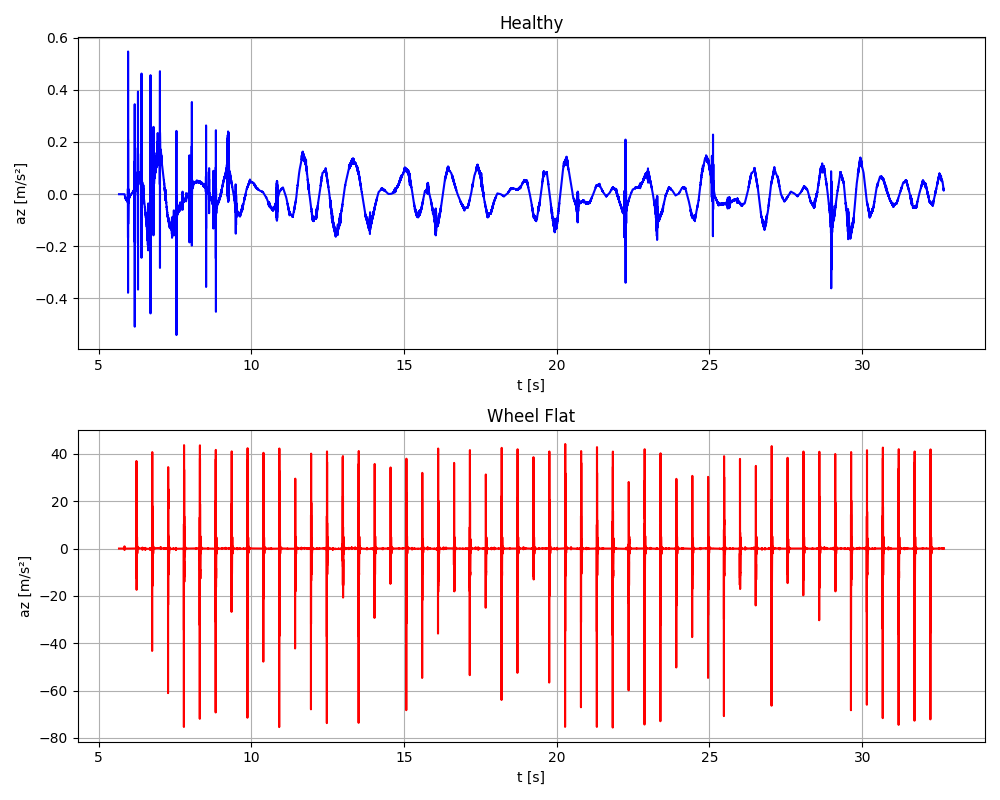

In [46]:
# Crear los subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Primer subplot: t vs az_no_flat_array
axs[0].plot(t, az_no_flat, label='Healthy', color='b')
axs[0].set_title('Healthy')
axs[0].set_xlabel('t [s]')
axs[0].set_ylabel('az [m/s²]')
axs[0].grid(True)
#axs[0].legend()

# Segundo subplot: az_no_flat_array
axs[1].plot(t,az_with_flat, label='Wheel Flat', color='r')
axs[1].set_title('Wheel Flat')
axs[1].set_xlabel('t [s]')
axs[1].set_ylabel('az [m/s²]')
axs[1].grid(True)
#axs[1].legend()

# Ajustar el layout
plt.tight_layout()

# Mostrar los gráficos
plt.show()

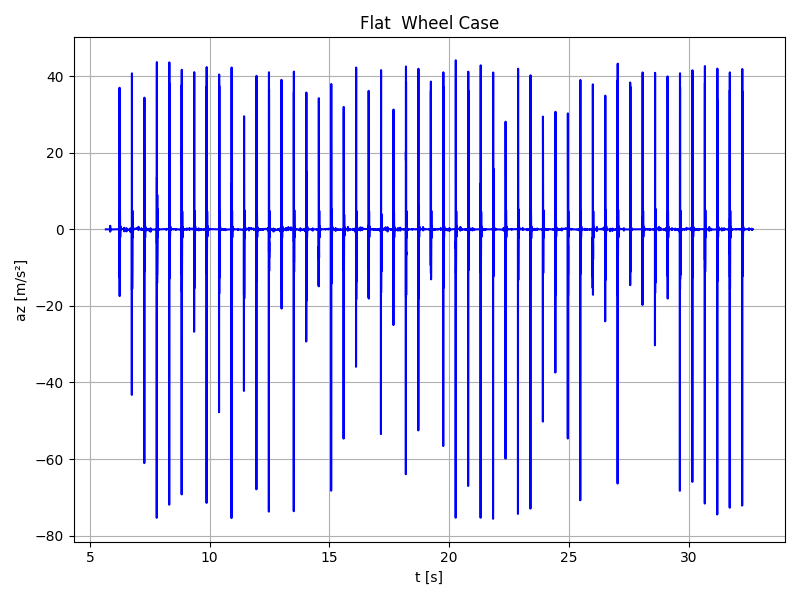

In [33]:
plt.figure(figsize=(8,6))
plt.plot(t,az_with_flat, label='Flat  Wheel Case', color='b')
plt.title('Flat  Wheel Case')
plt.xlabel('t [s]')
plt.ylabel('az [m/s²]')
plt.grid(True)
plt.tight_layout()
plt.show()

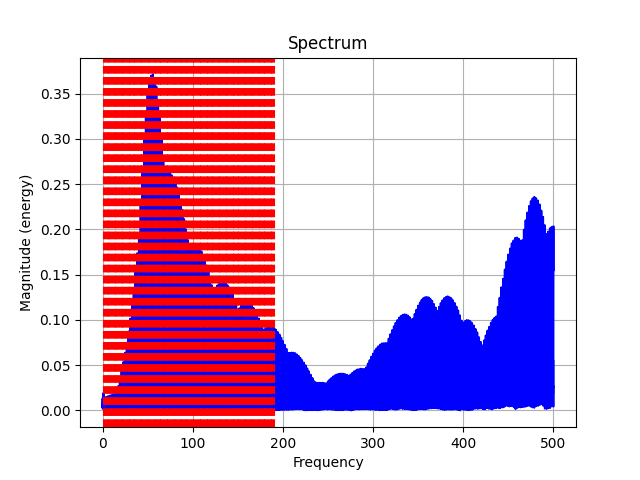

Max freq: 55.77571201066627


In [34]:
plt.close('all')
%matplotlib widget 
plt.title("Spectrum")
spectrum=plt.magnitude_spectrum(az_with_flat, Fs=fs, color='blue')
for i in range(1, 100):
    plt.axvline(x=i*fr, color='red', linestyle='--', label=f'{i}*fr' if i == 1 else None)
plt.grid(True)
plt.show()

print('Max freq:',spectrum[1][np.argmax(spectrum[0])])


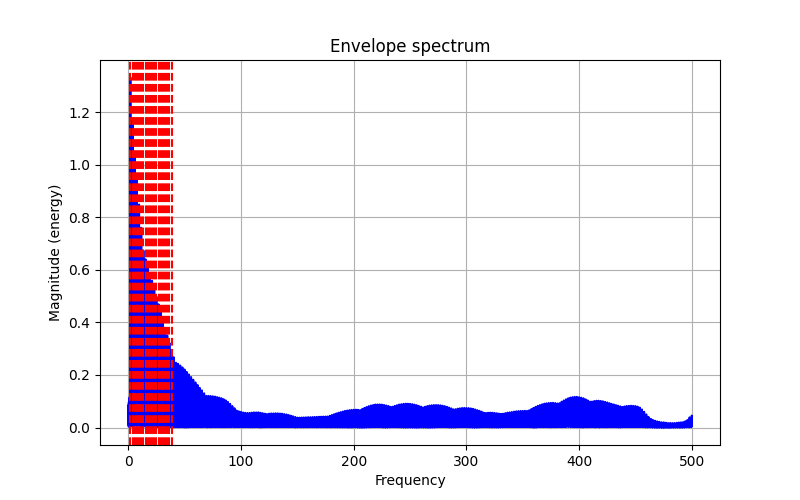

In [14]:
plt.close('all')
Sx_flax_env=np.abs(signal.hilbert(az_with_flat))
%matplotlib widget 
#%matplotlib inline
plt.figure(figsize=(8,5))
plt.title("Envelope spectrum")
spectrum=plt.magnitude_spectrum(Sx_flax_env-np.mean(Sx_flax_env), Fs=fs, color='blue')
for i in range(1, 21):
    plt.axvline(x=i*fr, color='red', linestyle='--', label=f'{i}*fr' if i == 1 else None)
plt.grid(True)
#plt.savefig('prueba_rm.pdf',bbox_inches='tight')
plt.show()


In [9]:
instantaneous_phase = np.unwrap(np.angle(signal.hilbert(az_with_flat)))
instantaneous_frequency = np.diff(instantaneous_phase) * fs / (2.0 * np.pi)
print(np.mean(instantaneous_frequency),np.std(instantaneous_frequency))
print(len(instantaneous_frequency))

"""
plt.close('all')
%matplotlib widget
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(instantaneous_frequency)) / fs, instantaneous_frequency)
plt.title('Frecuencia Instantánea')
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia [Hz]')
plt.grid(True)
plt.show()
"""

7.722490385718342 423.12500166832916
27000


"\nplt.close('all')\n%matplotlib widget\nplt.figure(figsize=(10, 6))\nplt.plot(np.arange(len(instantaneous_frequency)) / fs, instantaneous_frequency)\nplt.title('Frecuencia Instantánea')\nplt.xlabel('Tiempo [s]')\nplt.ylabel('Frecuencia [Hz]')\nplt.grid(True)\nplt.show()\n"

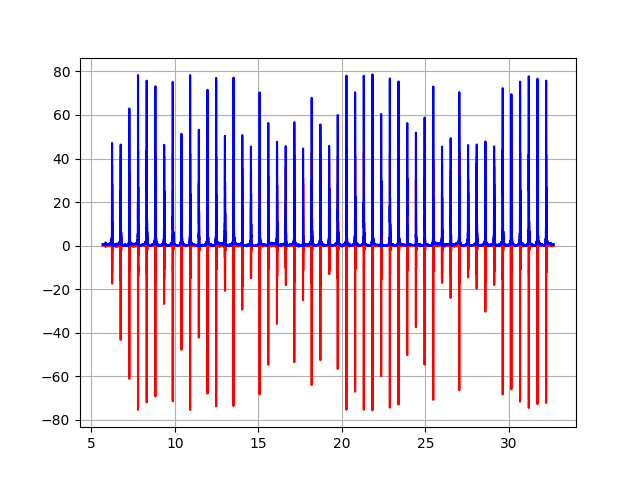

In [10]:
plt.close('all')
%matplotlib widget
plt.plot(t,az_with_flat, label='az FLAT', color='r')
plt.plot(t,Sx_flax_env, label='Envelope', color='b')
plt.grid(True)
plt.show()

### Simulating signal

#### Model: 

$y(k)=\sum_{r}A_r\sin\left(2\pi f\left[t_0+\dfrac{k}{F}-\dfrac{r}{f_m}\right]\right)\cdot e^{-\beta(L)\left(t_0 + \frac{k}{F}-\frac{r}{f_m}\right)}\cdot u\left(t_0+\dfrac{k}{F}-\dfrac{r}{f_m}\right)$

1.922161148452842


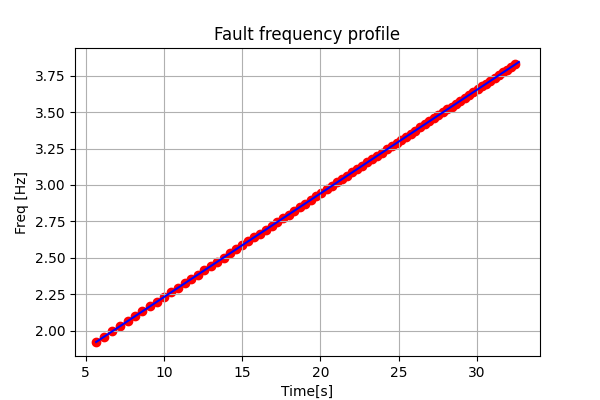

In [11]:
Ar= 1   #Amplitude
f = 55    #Resonant Frequency in Hz
b=10      #Exponential decay factor

n=np.arange(N)

#fr_var=curve_rayleigh(t)
v_var=1e3*np.linspace(20,40,N) # km/h
#v_var=20e3*np.ones((N,))

fr_var=v_var/(3600*2*np.pi*r)
print(np.min(fr_var))

f_fail=fr_var.copy()
ω_fail=2*np.pi*f_fail
θr_fail=np.cumsum(ω_fail)/fs

t_indexes=[]
t_impact=[]
N_of_impacts=np.int32(np.floor(np.max(θr_fail)/(2*np.pi)))+1
for i in range(N_of_impacts):
    t_index=np.argmin(np.abs(θr_fail-i*2*np.pi))
    t_indexes.append(t_index)
    t_impact.append(t[t_index])
    #print(i,t_index,t[t_index])

impacts=(np.array(t_indexes),np.array(t_impact))

plt.close('all')
%matplotlib widget
plt.figure(figsize=(6,4)) ### change tuple for better visualization or change inline for qt in %matplotlib inline 
plt.plot(t,f_fail,color='blue')
plt.title('Fault frequency profile')
plt.xlabel('Time[s]')
plt.ylabel('Freq [Hz]')
plt.grid()
plt.scatter(impacts[1],f_fail[impacts[0]],color='red',marker='o')
plt.show()

In [12]:
def conditional_exp(time_diff, b):
    return np.where(time_diff > 0, np.exp(-b * time_diff), 0)

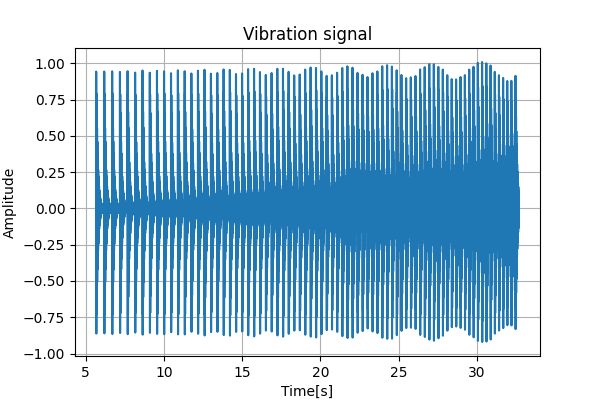

In [13]:
Sx_var=np.zeros((N,))

for r in range(len(t_impact)):
    time_diff=t[0]+n/fs-t_impact[r]
    #Sx_var+=Ar*np.sin(2*np.pi*f*(t[0]+n/fs-t_impact[r]))*np.exp(-b*(t[0]+n/fs-t_impact[r]))*np.heaviside(t[0]+n/fs-t_impact[r], 1)
    Sx_var+=Ar*np.sin(2*np.pi*f*(time_diff))*conditional_exp(time_diff, b)*np.heaviside(time_diff, 1)


plt.close('all')
%matplotlib widget
plt.figure(figsize=(6,4))
plt.plot(t,Sx_var)
plt.grid(True)
plt.title('Vibration signal')
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
plt.show()

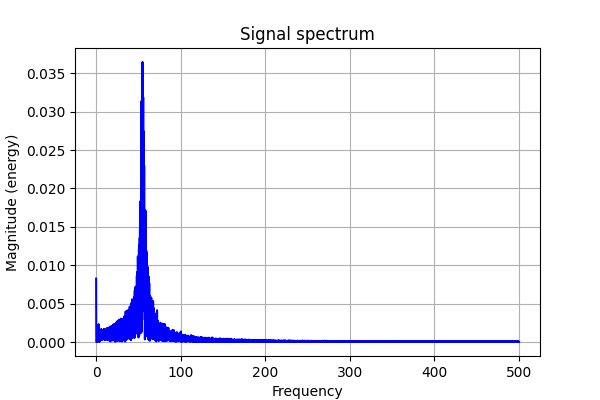

In [14]:
plt.close('all')
%matplotlib widget
plt.figure(figsize=(6,4))
spectrum=plt.magnitude_spectrum(Sx_var, Fs=fs, color='blue')
plt.title("Signal spectrum")
plt.grid(True)
plt.show()



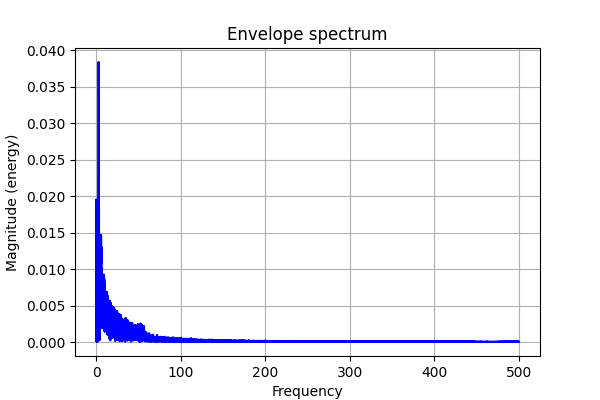

In [15]:
Sx_var_env=np.abs(signal.hilbert(Sx_var))

plt.close('all')
%matplotlib widget
plt.figure(figsize=(6,4))
plt.title("Envelope spectrum")
spectrum=plt.magnitude_spectrum(Sx_var_env-np.mean(Sx_var_env), Fs=fs, color='blue')
plt.grid(True)
#plt.savefig('env_spect.pdf',bbox_inches='tight')
plt.show()

In [16]:
Sx_var_env=Sx_var_env-np.mean(Sx_var_env)
λs=np.arange(0,10,1/16)
#fr=np.linspace(20,50,N)
fr_gd=fr_var.copy()
X_f0=[]
for λ in λs:
    f_num=λ*fr_gd
    f0=λ*fr_gd[0]
    S0_num=np.cumsum(f_num-f0)/fs
    d_2_num=signal.hilbert(Sx_var_env)*np.exp(-1j*2*np.pi*S0_num)
    spectrum=plt.magnitude_spectrum(d_2_num, Fs=fs, color='red')
    xf0=spectrum[0][(np.fabs(spectrum[1]-f0)).argmin(axis=0)] ### aqui en rigor habría que añadir una interpolación
    X_f0.append(xf0)

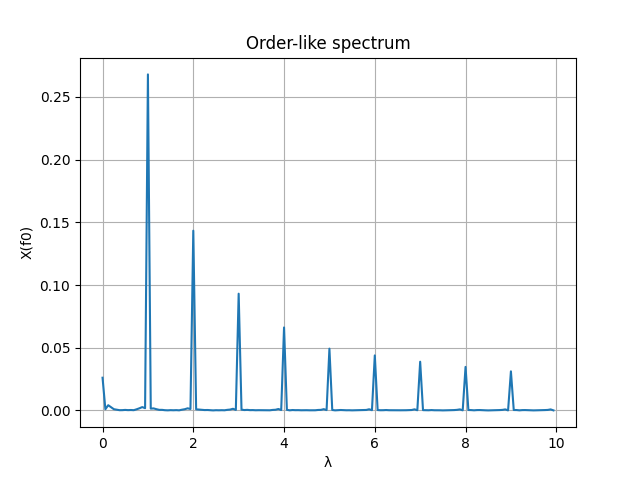

In [18]:
plt.close('all')
%matplotlib widget

plt.plot(λs,X_f0)
plt.xlabel('λ')
plt.ylabel('X(f0)')
plt.title("Order-like spectrum")
plt.grid(True)
#plt.savefig('lambda_spct.pdf',bbox_inches='tight')
plt.show()

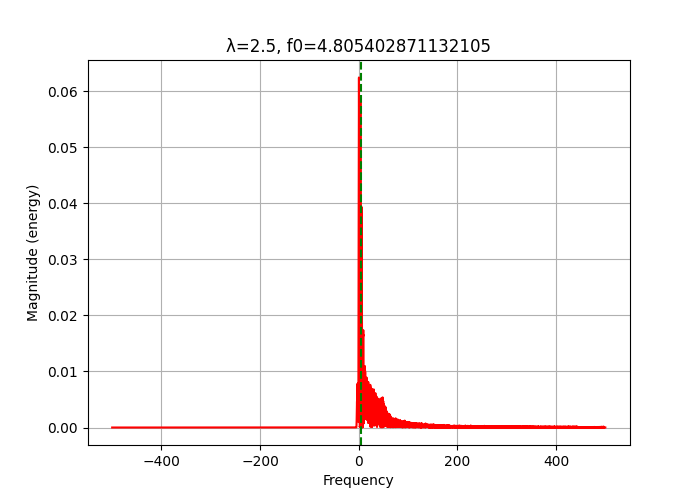

In [18]:
plt.close('all')
%matplotlib widget

λ=2.5 ### change
f_num=λ*fr_gd
f0=λ*fr_gd[0]
S0_num=np.cumsum(f_num-f0)/fs
d_2_num=signal.hilbert(Sx_var_env)*np.exp(-1j*2*np.pi*S0_num)
plt.figure(figsize=(7,5))

spectrum=plt.magnitude_spectrum(d_2_num, Fs=fs, color='red',lw=1.5)
#spectrum=plt.magnitude_spectrum(Sx_var_env-np.mean(Sx_var_env), Fs=fs, color='blue')
plt.axvline(x=f0,color='green',ls='--',lw=1.5)
plt.plot
plt.title('λ='+str(λ)+', f0='+str(f0))
plt.grid(True)

### Same but with csv signal

In [35]:
Sx_flax_env=Sx_flax_env-np.mean(Sx_flax_env)

λs=np.arange(0,10,1/16)
#fr=np.linspace(20,50,N)
fr_gd=fr*np.ones((N,1))
X_f0=[]
for λ in λs:
    f_num=λ*fr_gd
    f0=λ*fr_gd[0]
    S0_num=np.cumsum(f_num-f0)/fs
    d_2_num=signal.hilbert(Sx_flax_env)*np.exp(-1j*2*np.pi*S0_num)
    spectrum=plt.magnitude_spectrum(d_2_num, Fs=fs, color='red')
    xf0=spectrum[0][(np.fabs(spectrum[1]-f0)).argmin(axis=0)] ### aqui en rigor habría que añadir una interpolación
    X_f0.append(xf0)

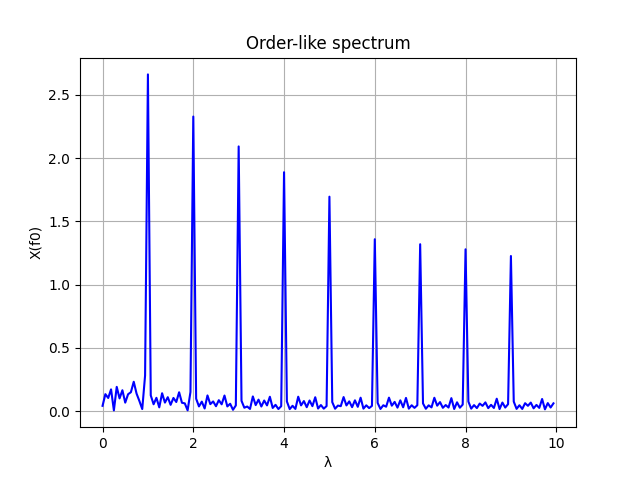

In [36]:
plt.close('all')
%matplotlib widget

plt.plot(λs,X_f0,color='blue')
plt.xlabel('λ')
plt.ylabel('X(f0)')
plt.title("Order-like spectrum")
plt.grid(True)
#plt.savefig('lambda_spct.pdf',bbox_inches='tight')
plt.show()

X_f0_faulty=X_f0.copy()

### No faulty signal

In [37]:
Sx_noflat_env=np.abs(signal.hilbert(az_no_flat))
Sx_noflat_env=Sx_noflat_env-np.mean(Sx_noflat_env)

λs=np.arange(0,10,1/16)
#fr=np.linspace(20,50,N)
fr_gd=fr*np.ones((N,1))
X_f0=[]
for λ in λs:
    f_num=λ*fr_gd
    f0=λ*fr_gd[0]
    S0_num=np.cumsum(f_num-f0)/fs
    d_2_num=signal.hilbert(Sx_noflat_env)*np.exp(-1j*2*np.pi*S0_num)
    spectrum=plt.magnitude_spectrum(d_2_num, Fs=fs, color='red')
    xf0=spectrum[0][(np.fabs(spectrum[1]-f0)).argmin(axis=0)] ### aqui en rigor habría que añadir una interpolación
    X_f0.append(xf0)

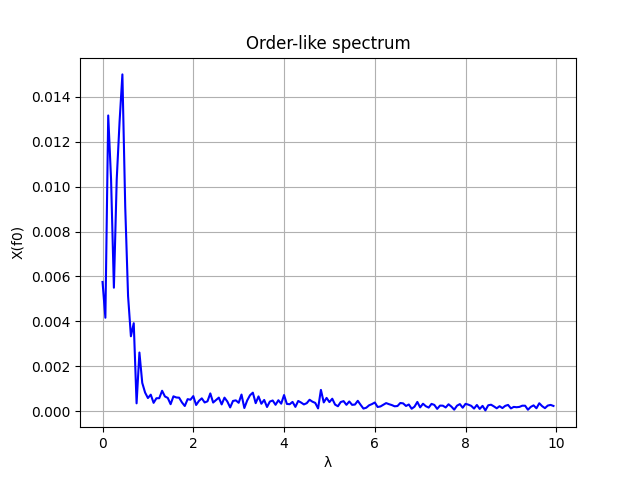

In [38]:
plt.close('all')
%matplotlib widget

plt.plot(λs,X_f0,color='blue')
plt.xlabel('λ')
plt.ylabel('X(f0)')
plt.title("Order-like spectrum")
plt.grid(True)
#plt.savefig('lambda_spct.pdf',bbox_inches='tight')
plt.show()

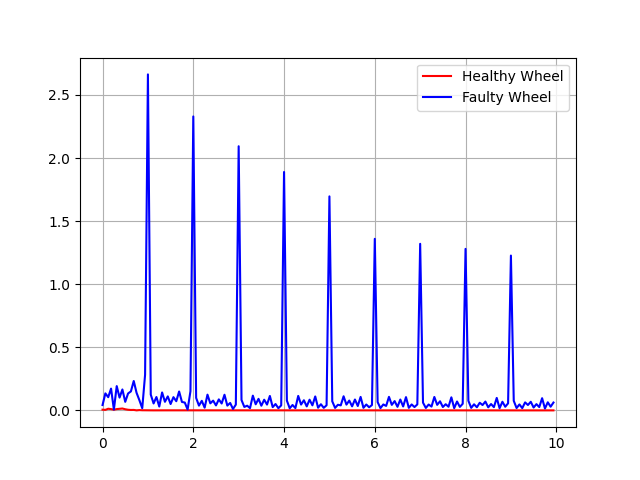

In [24]:
plt.close('all')
%matplotlib widget

plt.plot(λs,X_f0,color='red',label='Healthy Wheel')
plt.plot(λs,X_f0_faulty,color='blue',label='Faulty Wheel')
plt.grid(True)
plt.legend()
plt.show()

---

### Fast computation of $\lambda$ spectrum

Formally:

$\Lambda$: max value of $\lambda$

$D_\lambda$: $\lambda$ resolution

Then in order to have an integer index we can do $kD_\lambda = \lambda$ and $KD_\lambda = \Lambda$.

The transformation can be expressed in terms of a matrix multiplication in the form $\mathbf{X_k}=\mathbf{G}\mathbf{x_n}$, where the element $(n,k)$ of $\mathbf{G}$ can be expressed as:

$g(n,k)=\mathrm{e}^{-2\pi\mathrm{j}T_s D_\lambda k \sum_{i=0}^nf_r[i]}$

This matrix multiplication is $\mathcal{O}(KN)$ which is better than calculate $K$ FFT, with that grows $\mathcal{O}(KN\log{N})$ 

In [91]:
Λ=10
D_lambda=1/16
K=int(Λ/D_lambda)
Ts=1/fs
λs=np.arange(0,Λ,D_lambda)
print('K:',K)
print(len(f_fail))
print(Ts)

K: 160
27001
0.001


In [63]:
G=np.zeros((K,N),dtype=np.complex128)
for k in range(K):
    G[k,:]=np.exp(-1j*2*np.pi*D_lambda*k*Ts*np.cumsum(f_fail))

G.shape

(160, 27001)

In [64]:
Sx_var_env=Sx_var_env-np.mean(Sx_var_env)
Sx_env_analytic=signal.hilbert(Sx_var_env)
Sx_env_analytic.shape

(27001,)

In [71]:
X_lambda = (1/N)*np.dot(G, Sx_env_analytic)

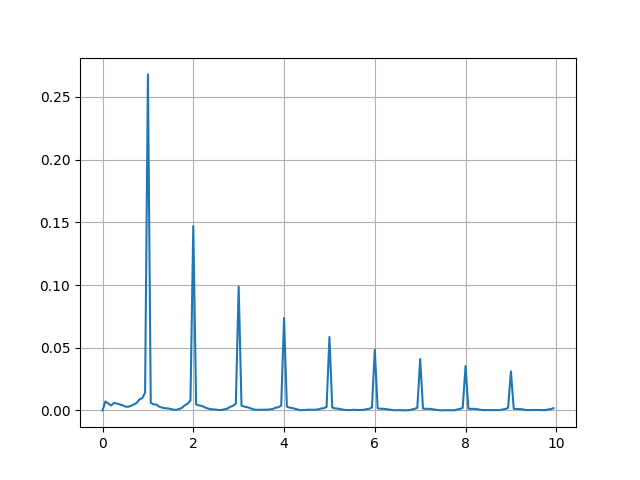

In [72]:
plt.close('all')
%matplotlib widget

plt.plot(λs,np.abs(X_lambda))
plt.grid(True)

In [86]:
v_var=20e3*np.ones((N,))
r=0.46
fr_var=v_var/(3600*2*np.pi*r)
f_fail=fr_var.copy()

In [87]:
G=np.zeros((K,N),dtype=np.complex128)
for k in range(K):
    G[k,:]=np.exp(-1j*2*np.pi*D_lambda*k*Ts*np.cumsum(f_fail))

Sx_flax_env=Sx_flax_env-np.mean(Sx_flax_env)
Sx_env_analytic=signal.hilbert(Sx_flax_env)
print(G.shape, Sx_env_analytic.shape)

X_lambda = (1/N)*np.dot(G, Sx_env_analytic)

(160, 27001) (27001,)


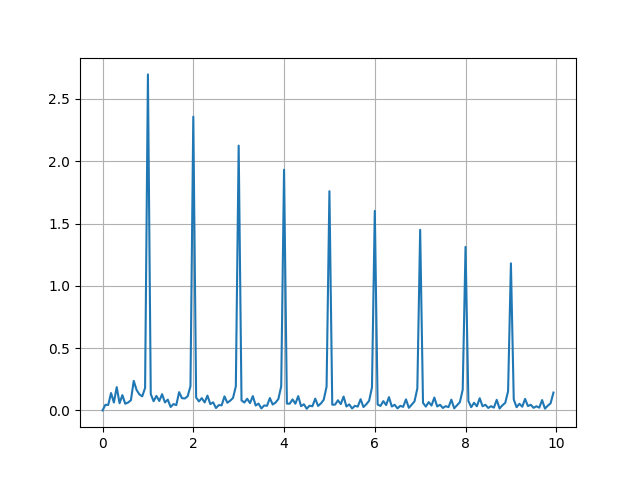

In [88]:
plt.close('all')
%matplotlib widget

plt.plot(λs,np.abs(X_lambda))
plt.grid(True)